In [1]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch

2023-04-12 03:24:32.818513: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-12 03:24:32.818534: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-xxl")

In [4]:
from src.utils.wordstats import *

In [5]:
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-xxl", device_map="auto")

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /tmp/ipykernel_1695171/1043345471.py:1 in <module>                                        │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_1695171/1043345471.py'               │
│ /home/prasann/miniconda3/envs/rewardenv/lib/python3.8/site-packages/transformers/modeling │
│ _utils.py:2403 in from_pretrained                                                         │
│                                                                                           │
│   2400 │   │   │   elif device_map in ["balanced", "balanced_low_0"] and get_balanced_mem │
│   2401 │   │   │   │   raise ValueError(f"`device_map={device_map}` requires a source ins │
│   2402 │   │   │   if device_map != "sequential" and get_balanced_memory is not None:     │
│ ❱ 2403 │   │   │   │   max_memory = get_balanced_memory(                                  │
│   2404 │   │   │   │   │   model,                                                         │
│   2405 │   │   │   │   │   max_memory=max_memory,                                         │
│   2406 │   │   │   │   │   no_split_module_classes=no_split_modules,                      │
│                                                                                           │
│ /home/prasann/miniconda3/envs/rewardenv/lib/python3.8/site-packages/accelerate/utils/mode │
│ ling.py:412 in get_balanced_memory                                                        │
│                                                                                           │
│   409 │   │   │   Transformers generate function).                                        │
│   410 │   """                                                                             │
│   411 │   # Get default / clean up max_memory                                             │
│ ❱ 412 │   max_memory = get_max_memory(max_memory)                                         │
│   413 │                                                                                   │
│   414 │   if not torch.cuda.is_available():                                               │
│   415 │   │   return max_memory                                                           │
│                                                                                           │
│ /home/prasann/miniconda3/envs/rewardenv/lib/python3.8/site-packages/accelerate/utils/mode │
│ ling.py:324 in get_max_memory                                                             │
│                                                                                           │
│   321 │   │   else:                                                                       │
│   322 │   │   │   # Make sure CUDA is initialized on each GPU to have the right memory in │
│   323 │   │   │   for i in range(torch.cuda.device_count()):                              │
│ ❱ 324 │   │   │   │   _ = torch.tensor([0], device=i)                                     │
│   325 │   │   │   max_memory = {i: torch.cuda.mem_get_info(i)[0] for i in range(torch.cud │
│   326 │   │   max_memory["cpu"] = psutil.virtual_memory().available                       │
│   327 │   │   return max_memory                                                           │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace 
below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from statistics import stdev
import numpy as np
from scipy.stats import spearmanr

In [6]:
def mean(l):
    if len(l)==0:
        #print("0 len?")
        return 0
    return sum(l)/len(l)

In [7]:
EBASE = "output/exhaustive/"
ind = 49
e = pd.read_json(EBASE+"ex"+str(ind)+".jsonl", orient="records", lines=True)

In [8]:
len(e['inp'].unique())

50

(array([ 1.,  0.,  1.,  5.,  8.,  7., 12.,  6.,  6.,  4.]),
 array([0.37389841, 0.42899461, 0.4840908 , 0.53918699, 0.59428319,
        0.64937938, 0.70447557, 0.75957176, 0.81466796, 0.86976415,
        0.92486034]),
 <BarContainer object of 10 artists>)

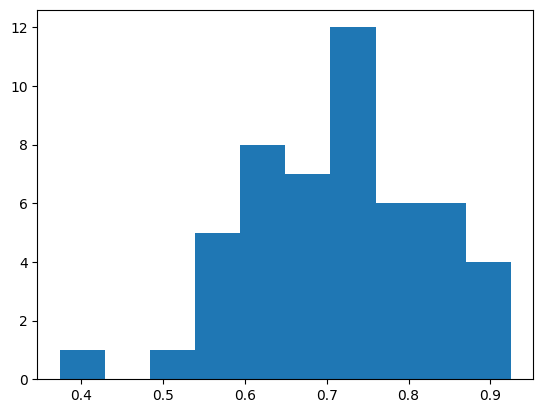

In [100]:

firsts = e[e['ver']=="first"].reset_index()
def random_base(fdf):
    values = []
    for i in range(len(fdf)):
        values.append(mean(fdf.iloc[i]['scos']))
    return values

plt.hist(random_base(firsts))

In [ ]:
e[]

In [163]:
def mean_nidf(idict, text):
    words = re.findall(r'\w+', text.lower())
    fwords = []
    for w in words:
        if w in idict.keys():
            fwords.append(w)
    return mean([idict[w] for w in fwords])

def extract_scatter(datadf, uses):
    uns = list(datadf['inp'].unique())
    scatys = []
    allstats = {
        'mean':[],
        'stdev':[],
        'entropy':[],
        'skewness':[],
        'kurtoses':[],
        'top1s':[],
        'selected':[]
    }
    scovals = []
    prefpercs = []
    prefs = []
    strs = []
    nidfs = []
    selstrs = []
    inprompts = []
    shpvars = []
    for u in uns:
        # focus on one at a time
        tmpdf = datadf[datadf['inp']==u]
        # TODO compress this code
        if "worst" in uses:
            wentry = tmpdf[tmpdf['ver']=='first'].iloc[0]
            # get worst ind
            wind = np.argmin(wentry['scos'])
            wtmp = tmpdf[tmpdf['ver']=="worst"]
            wtoks = tokenizer(wentry['hyps'][wind]).input_ids
            # Calculate the max of the 'scos' list for each row and store it in a new column
            wtmp['max_scos'] = wtmp['scos'].apply(lambda x: max(x))
            shpvars.extend(wtmp['scos'].apply(lambda x: stdev(x)))
            # Get the value in the input array at the index of each row's prefix value
            for a in allstats.keys():
                # extend with prefix based indexed thing
                allstats[a].extend(wtmp.apply(lambda row: wentry['stats'][a][int(row['prefix'])][wind], axis=1))
            wtmp['istrs'] = wtmp.apply(lambda row: [tokenizer.decode(w) for w in wtoks], axis=1)
            strs.extend(wtmp['istrs'])
            
            scatys.extend(wtmp['max_scos']- wentry['scos'][wind])
            scovals.extend([wentry['scos'][wind]]*len(wtmp))
            prefpercs.extend(wtmp['prefix']/len(wtmp['istrs'].iloc[0]))
            prefs.extend(wtmp['prefix'])
            wtmp['sel'] = wtmp.apply(lambda row: np.argmax(row['scos']), axis=1)
            seltmp = wtmp.apply(lambda row: [tokenizer(row['hyps'][row['sel']]).input_ids], axis=1)
            seltmp = [[tokenizer.decode(w) for w in sel] for sel in seltmp]
            selstrs.extend(seltmp)
            inprompts.exted(wtmp['inp'])
        elif "best" in uses:
            wentry = tmpdf[tmpdf['ver']=='first'].iloc[0]
            # get worst ind
            wind = np.argmax(wentry['scos'])
            wtoks = tokenizer(wentry['hyps'][wind]).input_ids
            wtmp = tmpdf[tmpdf['ver']=="best"]
            # Calculate the max of the 'scos' list for each row and store it in a new column
            wtmp['max_scos'] = wtmp['scos'].apply(lambda x: max(x))
            shpvars.extend(wtmp['scos'].apply(lambda x: stdev(x)))
            # Get the value in the input array at the index of each row's prefix value
            for a in allstats.keys():
                # extend with prefix based indexed thing
                allstats[a].extend(wtmp.apply(lambda row: wentry['stats'][a][int(row['prefix'])][wind], axis=1))
            nidfdict = nidf(wentry['hyps'][wind])
            wtmp['istrs'] = wtmp.apply(lambda row: [tokenizer.decode(w) for w in wtoks], axis=1)
            strs.extend(wtmp['istrs'])
            #nidfs.extend(wtmp.apply(lambda row: mean_nidf(nidfdict, row['istrs']), axis=1))
            scatys.extend(wtmp['max_scos'] - wentry['scos'][wind])
            scovals.extend([wentry['scos'][wind]]*len(wtmp))
            prefpercs.extend(wtmp['prefix']/len(wtmp['istrs'].iloc[0]))
            prefs.extend(wtmp['prefix'])
            wtmp['sel'] = wtmp.apply(lambda row: np.argmax(row['scos']), axis=1)
            seltmp = wtmp.apply(lambda row: [tokenizer(row['hyps'][row['sel']]).input_ids], axis=1)
            seltmp = [[tokenizer.decode(w) for w in sel] for sel in seltmp]
            selstrs.extend(seltmp)
            inprompts.extend(wtmp['inp'])
    allstats['inpstrs'] = strs
    allstats['improves'] = scatys
    allstats['initsco'] = scovals
    allstats['prefpercent'] = prefpercs
    allstats['prefix'] = prefs
    allstats['selstrs'] = selstrs
    allstats['prompt'] = inprompts
    allstats['stdevs'] = shpvars
    #allstats['mean_nidf'] = nidfs
    return pd.DataFrame(allstats)
        

In [ ]:
resdf  = extract_scatter(e, ['best'])
#resdf['selstrs'] = resdf.apply(lambda row: [tokenizer.decode(t) for t in tokenizer(row['selstrs'][0]).input_ids], axis=1)

In [165]:
resdf

,mean,stdev,entropy,skewness,kurtoses,top1s,selected,inpstrs,improves,initsco,prefpercent,prefix,selstrs,prompt,stdevs
0,0.000031,0.005326,0.2321,179.00,32070.0,0.9543,0.9543,"[The, body, naturally, burn, s, calories, to, ...",-0.116369,0.850852,0.022388,3.0,"[The body burns calories in a number of ways, ...",Explain like I'm five years old: How does your...,0.171495
1,0.000031,0.005579,0.0000,179.20,32120.0,1.0000,1.0000,"[The, body, naturally, burn, s, calories, to, ...",-0.116918,0.850852,0.029851,4.0,[The body naturally burns a certain amount of ...,Explain like I'm five years old: How does your...,0.054129
2,0.000031,0.004141,1.0870,173.50,30690.0,0.7338,0.7338,"[The, body, naturally, burn, s, calories, to, ...",-0.155831,0.850852,0.037313,5.0,[The body naturally burns calories at a rate o...,Explain like I'm five years old: How does your...,0.184409
3,0.000031,0.001755,2.7190,96.74,11510.0,0.2365,0.2365,"[The, body, naturally, burn, s, calories, to, ...",-0.098341,0.850852,0.044776,6.0,[The body naturally burns calories at a slow b...,Explain like I'm five years old: How does your...,0.229578
4,0.000031,0.002951,1.7650,129.10,17730.0,0.4394,0.2772,"[The, body, naturally, burn, s, calories, to, ...",-0.354737,0.850852,0.052239,7.0,[The body naturally burns calories throughout ...,Explain like I'm five years old: How does your...,0.094000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3372,0.000031,0.002265,1.9960,88.34,8471.0,0.2567,0.1924,"[The, laugh, track, was, initially, used, to, ...",0.016264,0.947469,0.941860,81.0,[The laugh track was initially used to replace...,eli5: Why were laugh tracks so widely used on ...,0.005703
3373,0.000031,0.005579,0.0000,179.20,32120.0,1.0000,1.0000,"[The, laugh, track, was, initially, used, to, ...",0.009833,0.947469,0.953488,82.0,[The laugh track was initially used to replace...,eli5: Why were laugh tracks so widely used on ...,0.002972
3374,0.000031,0.005063,0.4376,178.50,31940.0,0.9062,0.9062,"[The, laugh, track, was, initially, used, to, ...",0.009444,0.947469,0.965116,83.0,[The laugh track was initially used to replace...,eli5: Why were laugh tracks so widely used on ...,0.004328
3375,0.000031,0.003017,1.4610,116.40,14620.0,0.4267,0.2257,"[The, laugh, track, was, initially, used, to, ...",0.006975,0.947469,0.976744,84.0,[The laugh track was initially used to replace...,eli5: Why were laugh tracks so widely used on ...,0.003308


(array([263., 350., 345., 345., 349., 344., 348., 349., 347., 337.]),
 array([0.01244813, 0.11078838, 0.20912863, 0.30746888, 0.40580913,
        0.50414938, 0.60248963, 0.70082988, 0.79917012, 0.89751037,
        0.99585062]),
 <BarContainer object of 10 artists>)

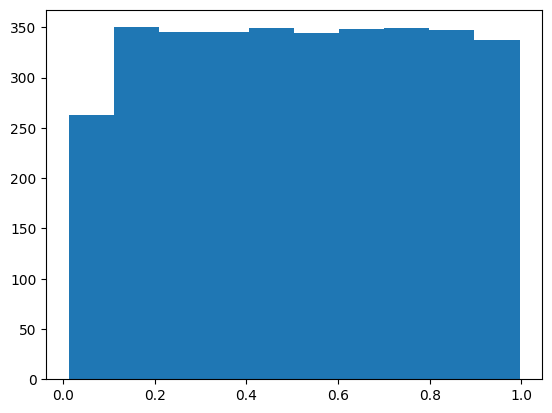

In [33]:
plt.hist(resdf['prefpercent'])

Explain like I'm five years old: Why is Blackjack the only mathematically beatable game in casino?
0.8082352281
FULL START
['Blackjack', 'has', 'the', 'highest', 'house', 'edge', 'of', 'any', 'casino', 'game', ',', 'at', 'nearly', '', '5%', '.', 'The', 'advantage', 'of', 'the', 'house', 'is', 'mitigate', 'd', 'by', 'the', 'rule', 'of', '21', '.', 'Therefore', ',', 'only', 'blackjack']
PARTIAL START
['Blackjack', 'has', 'the', 'highest', 'house', 'edge', 'of', 'any', 'casino', 'game', ',', 'at', 'nearly', '', '5%', '.', 'The', 'advantage', 'of', 'the', 'house', 'is', 'mitigate', 'd', 'by', 'the', 'rule', 'of', '21', '.', 'Therefore', ',', 'only', 'blackjack', 'can', 'be', 'mathematical', 'ly', 'beat', 'able', 'and', 'the', 'house', 'advantage', 'must', 'be', 'reduced', 'to', 'close', 'to', 'zero', '.', '</s>']
53


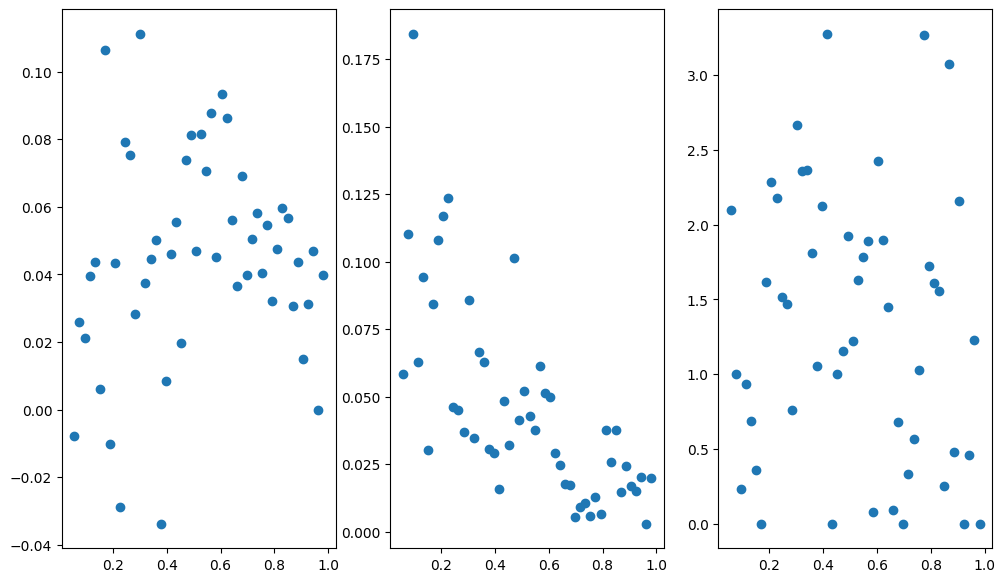

In [228]:
# get individual prefix scatters
smans = []
alluns = list(resdf['initsco'].unique())
vind = 12
subset = resdf[resdf['initsco']==alluns[vind]]
print(subset['prompt'].iloc[0])
print(alluns[vind])
print("FULL START")
print(subset['inpstrs'].iloc[0][:int(ilen*1)])
ilen = len(subset['inpstrs'].iloc[0])
ratio=1
print("PARTIAL START")
print(subset['inpstrs'].iloc[0][:int(ilen*ratio)])
print(len(subset['inpstrs'].iloc[0]))
fig, ax = plt.subplots(1, 3, figsize=(12, 7))
ax[0].scatter(subset['prefpercent'].iloc[:int(ilen*ratio)], subset['improves'].iloc[:int(ilen*ratio)])
ax[1].scatter(subset['prefpercent'].iloc[:int(ilen*ratio)], subset['stdevs'].iloc[:int(ilen*ratio)])
ax[2].scatter(subset['prefpercent'].iloc[:int(ilen*ratio)], subset['entropy'].iloc[:int(ilen*ratio)])


In [43]:
wauns = []
for a in alluns:
    if a<.75:
        wauns.append(a)

In [22]:
subset

,mean,stdev,entropy,skewness,kurtoses,top1s,selected,inpstrs,improves,initsco,prefpercent,prefix,selstrs
478,0.000031,0.005579,0.0000,179.2,32120.0,1.0000,1.000000,"[The, faster, , a, moving, object, is, ,, the,...",0.408319,0.404301,0.033333,3.0,"[The, best, -, performing, , t, y, re, s, (, f..."
479,0.000031,0.003433,1.1030,121.7,15210.0,0.4563,0.009828,"[The, faster, , a, moving, object, is, ,, the,...",0.422899,0.404301,0.044444,4.0,"[The, best, compromise, between, handling, and..."
480,0.000031,0.004778,0.5112,174.4,30870.0,0.8480,0.848000,"[The, faster, , a, moving, object, is, ,, the,...",0.479819,0.404301,0.055556,5.0,"[The, best, compromise, between, weight, and, ..."
481,0.000031,0.003884,1.1760,168.2,29320.0,0.6804,0.680400,"[The, faster, , a, moving, object, is, ,, the,...",0.445646,0.404301,0.066667,6.0,"[The, best, compromise, between, performance, ..."
482,0.000031,0.004997,0.4109,176.7,31490.0,0.8912,0.891200,"[The, faster, , a, moving, object, is, ,, the,...",0.455465,0.404301,0.077778,7.0,"[The, best, compromise, between, performance, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,0.000031,0.003710,1.6200,174.0,30830.0,0.6583,0.008209,"[The, faster, , a, moving, object, is, ,, the,...",0.414638,0.404301,0.955556,86.0,"[The, best, compromise, between, performance, ..."
562,0.000031,0.003705,1.6250,174.0,30830.0,0.6573,0.657300,"[The, faster, , a, moving, object, is, ,, the,...",0.414795,0.404301,0.966667,87.0,"[The, best, compromise, between, performance, ..."
563,0.000031,0.003667,1.6510,173.8,30770.0,0.6503,0.650300,"[The, faster, , a, moving, object, is, ,, the,...",0.417017,0.404301,0.977778,88.0,"[The, best, compromise, between, performance, ..."
564,0.000031,0.003663,1.6630,173.8,30790.0,0.6496,0.649600,"[The, faster, , a, moving, object, is, ,, the,...",0.471832,0.404301,0.988889,89.0,"[The, best, compromise, between, performance, ..."


In [44]:
#resdf['nidf'] = resdf.apply(lambda row: nidf(row['inpstrs']), axis=1)
#print("nidf")
#resdf['tfidf'] = resdf.apply(lambda row: tf_idf(row['inpstrs']), axis=1)
#print("tfidf")
#resdf['f_kinc'] =  resdf.apply(lambda row: flesch_kincaid(row['inpstrs']), axis=1)
#resdf['smog'] =  resdf.apply(lambda row: smog(row['inpstrs']), axis=1)
#resdf['gfog'] =  resdf.apply(lambda row: gunning_fog(row['inpstrs']), axis=1)
#resdf['f_kinc'] =  resdf.apply(lambda row: flesch_kincaid(row['inpstrs']), axis=1)
resdf['coleman'] =  resdf.apply(lambda row: coleman_liau(row['inpstrs']), axis=1)


In [45]:
resdf

,mean,stdev,entropy,skewness,kurtoses,top1s,selected,inpstrs,improves,initsco,prefpercent,prefix,mean_nidf,coleman
0,0.000031,0.005326,0.2321,179.00,32070.0,0.9543,0.9543,The body naturally,-0.116369,0.850852,0.022556,3.0,0.946627,5.693333
1,0.000031,0.005579,0.0000,179.20,32120.0,1.0000,1.0000,The body naturally burn,-0.116918,0.850852,0.030075,4.0,1.083998,6.200000
2,0.000031,0.004141,1.0870,173.50,30690.0,0.7338,0.7338,The body naturally burns,-0.155831,0.850852,0.037594,5.0,1.603858,7.670000
3,0.000031,0.001755,2.7190,96.74,11510.0,0.2365,0.2365,The body naturally burns calories,-0.098341,0.850852,0.045113,6.0,2.306285,12.384000
4,0.000031,0.002951,1.7650,129.10,17730.0,0.4394,0.2772,The body naturally burns calories to,-0.354737,0.850852,0.052632,7.0,1.921572,9.646667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3372,0.000031,0.002265,1.9960,88.34,8471.0,0.2567,0.1924,The laugh track was initially used to replace ...,0.016264,0.947469,0.952941,81.0,1.079536,10.654286
3373,0.000031,0.005579,0.0000,179.20,32120.0,1.0000,1.0000,The laugh track was initially used to replace ...,0.009833,0.947469,0.964706,82.0,1.079536,10.530141
3374,0.000031,0.005063,0.4376,178.50,31940.0,0.9062,0.9062,The laugh track was initially used to replace ...,0.009444,0.947469,0.976471,83.0,1.079536,10.778592
3375,0.000031,0.003017,1.4610,116.40,14620.0,0.4267,0.2257,The laugh track was initially used to replace ...,0.006975,0.947469,0.988235,84.0,1.064331,10.861408


In [19]:
def get_traintest(rdf, ratio):
    auns = rdf['initsco'].unique()
    cutind = int(len(auns)*ratio)+1
    tmp = rdf[rdf['initsco']==auns[cutind]].reset_index()
    cutind = int(tmp.iloc[0]['index'])
    return rdf.iloc[:cutind], rdf.iloc[cutind:]
        

In [47]:
trainrdf, testrdf = get_traintest(resdf, 0.8)

In [20]:
# write simple code, see if simple model does the trick
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [21]:
thresh = 0
def balance_labels(df):
    # Separate the DataFrame into two based on the condition
    above_zero_df = df[df['improves'] >= 0]
    below_zero_df = df[df['improves'] < 0]

    # Calculate the difference in lengths
    length_diff = len(above_zero_df) - len(below_zero_df)

    # Drop rows from the dominant class
    if length_diff > thresh:
        above_zero_df = above_zero_df.sample(len(below_zero_df))
    elif length_diff < thresh:
        below_zero_df = below_zero_df.sample(len(above_zero_df))

    # Concatenate the two balanced DataFrames
    return pd.concat([above_zero_df, below_zero_df], axis=0).reset_index(drop=True)


In [69]:
btraindf = balance_labels(trainrdf)
btestdf = balance_labels(testrdf)

In [70]:
X_train = btraindf.drop("improves", axis=1)
X_train = X_train.drop("inpstrs", axis=1)
y_train = btraindf['improves']
X_test = btestdf.drop("improves", axis=1)
X_test = X_test.drop("inpstrs", axis=1)
y_test = btestdf['improves']

(array([  0.,   0.,   0.,   0.,   0., 212.,   0.,   0.,   0.,   0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

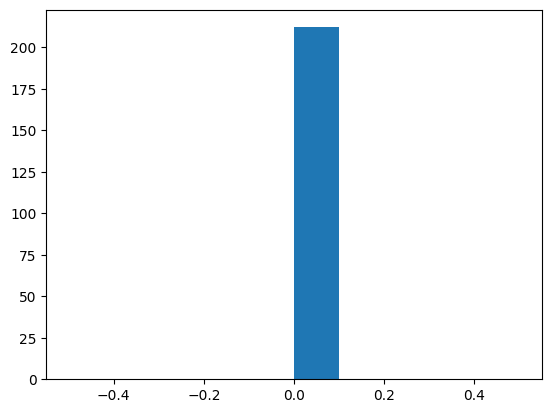

In [71]:
plt.hist(list([int(f) for f in y_test]))

In [72]:
# Classification Setup
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load your pandas DataFrame
# df = pd.read_csv('your_file.csv')
y_train = y_train > thresh
y_test = y_test > thresh

# List of models to try
models = [
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42)),
    ('SVM', SVC(random_state=42)),
]

# Evaluate the performance of each model
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print("positive preds"+str(sum(y_pred)/len(y_pred)))
    print(f'{name}:')
    print(f'  Accuracy: {accuracy:.4f}')
    print(f'  Precision: {precision:.4f}')
    print(f'  Recall: {recall:.4f}')
    print(f'  F1 Score: {f1:.4f}')
    print()

positive preds0.1650943396226415
Logistic Regression:
  Accuracy: 0.5896
  Precision: 0.7714
  Recall: 0.2547
  F1 Score: 0.3830

positive preds0.5141509433962265
Random Forest:
  Accuracy: 0.5708
  Precision: 0.5688
  Recall: 0.5849
  F1 Score: 0.5767

positive preds0.5943396226415094
Gradient Boosting:
  Accuracy: 0.5849
  Precision: 0.5714
  Recall: 0.6792
  F1 Score: 0.6207

positive preds0.0
SVM:
  Accuracy: 0.5000
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000



/home/prasann/miniconda3/envs/rewardenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Hyperparameter tuning for RandomForestClassifier using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='f1', cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best hyperparameters for RandomForestClassifier: {best_params}")

# Train the model with the best hyperparameters and evaluate its performance
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Random Forest with best hyperparameters:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1 Score: {f1:.4f}")

In [104]:
# REGRESSION setup
# List of models to try
models = [
    ('Linear Regression', LinearRegression()),
    ('Ridge', Ridge()),
    ('Lasso', Lasso()),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42)),
]

# Evaluate the performance of each model
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'{name}:')
    print(f'  Mean Squared Error: {mse:.4f}')
    print(f'  R2 Score: {r2:.4f}')
    print()

Linear Regression:
  Mean Squared Error: 0.0035
  R2 Score: 0.0640

Ridge:
  Mean Squared Error: 0.0035
  R2 Score: 0.0623

Lasso:
  Mean Squared Error: 0.0041
  R2 Score: -0.0965

Random Forest:
  Mean Squared Error: 0.0046
  R2 Score: -0.2274

Gradient Boosting:
  Mean Squared Error: 0.0040
  R2 Score: -0.0649



In [ ]:
from sklearn.model_selection import GridSearchCV

# Hyperparameters to tune for GradientBoostingRegressor
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
}

# Perform grid search on GradientBoostingRegressor
gbm = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, scoring='r2', cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Train the model with the best hyperparameters and evaluate its performance
best_gbm = GradientBoostingRegressor(**best_params, random_state=42)
best_gbm.fit(X_train, y_train)
y_pred = best_gbm.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Gradient Boosting with best hyperparameters:")
print(f"  Mean Squared Error: {mse:.4f}")
print(f"  R2 Score: {r2:.4f}")

In [94]:
min_class_size = resdf['initsco'].value_counts().min()

# Group by class_id, sample the rows and concatenate the result
balanced = resdf.groupby('initsco').apply(lambda x: x.sample(min_class_size)).reset_index(drop=True)


In [40]:
resdf

,improves,stat,initsco,prefpercent
0,-0.116369,0.2321,0.850852,0.022388
1,-0.116918,0.0000,0.850852,0.029851
2,-0.155831,1.0870,0.850852,0.037313
3,-0.098341,2.7190,0.850852,0.044776
4,-0.354737,1.7650,0.850852,0.052239
...,...,...,...,...
3372,0.016264,1.9960,0.947469,0.609023
3373,0.009833,0.0000,0.947469,0.616541
3374,0.009444,0.4376,0.947469,0.624060
3375,0.006975,1.4610,0.947469,0.631579


In [60]:
start = resdf[resdf['initsco']<0.85].reset_index()

In [66]:
# get correlation histogram plots
smans = []
alluns = list(start['initsco'].unique())

for i in range(len(alluns)):
    subset = start[start['initsco']==alluns[i]]
    smans.append(spearmanr(subset['kurtoses'], subset['improves']).correlation)

In [36]:
origs = e[e['ver']=="worst"]

0.40430080890000003


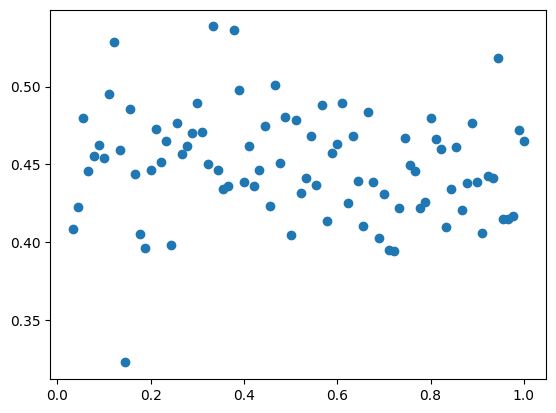

In [38]:
# get individual prefix scatters
smans = []
alluns = list(resdf['initsco'].unique())
vind = 5
subset = resdf[resdf['initsco']==alluns[vind]]
print(alluns[vind])
plt.scatter(subset['prefpercent'], subset['improves'])

In [48]:
inits = e[e['ver']=='first']

In [ ]:
inits[inits['inpstr']=="Explain like I'm five years old: why do the fastest bicycles have really thin tyres but the fastest cars have very wide tyres"]

In [45]:
origs.iloc[565]['hyps'][0]

'The best compromise between performance and comfort is achieved with a tyre that is essentially the same width across the contact patch, but with different pressures. The narrower the tyre, the more pressure it can take, but the thinner the tyre, the less force it can take. So if you want to travel fast, the narrower the tyre, the more force you need.'

In [29]:
test = balanced[balanced['prefpercent']>0.3]

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /tmp/ipykernel_1695171/1021348429.py:1 in <module>                                        │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_1695171/1021348429.py'               │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'balanced' is not defined

In [91]:
spearmanr(test['entropy'], test['improves'])

SpearmanrResult(correlation=0.003782267993635742, pvalue=0.9230322120352731)

In [ ]:
def make_impred_dset(edf):
    

(array([ 2.,  1.,  2.,  2.,  1.,  4.,  6., 14., 11.,  7.]),
 array([0.5616672 , 0.60214622, 0.64262524, 0.68310425, 0.72358327,
        0.76406229, 0.8045413 , 0.84502032, 0.88549933, 0.92597835,
        0.96645737]),
 <BarContainer object of 10 artists>)

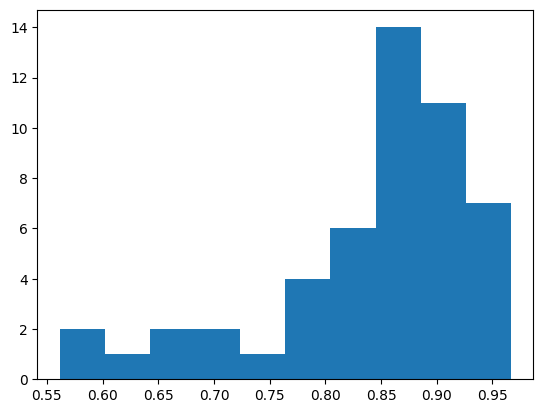

In [87]:
plt.hist(balanced['initsco'].unique())

(array([ 18.,  36., 108.,  90., 144., 180.,  90.,  72.,  72.,  90.]),
 array([0.20809419, 0.27462578, 0.34115736, 0.40768895, 0.47422054,
        0.54075212, 0.60728371, 0.67381529, 0.74034688, 0.80687846,
        0.87341005]),
 <BarContainer object of 10 artists>)

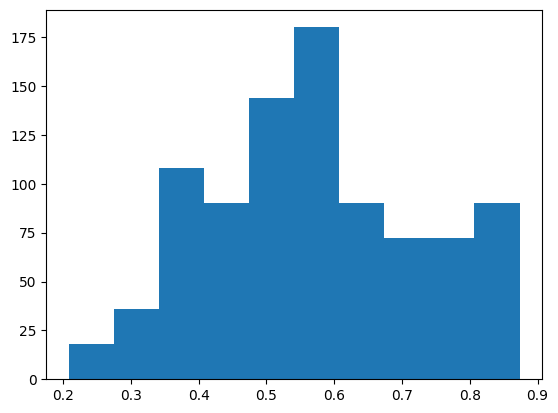

In [127]:
plt.hist(balanced['initsco'])

(array([ 17.,  89., 137.,  68., 270., 117.,  72.,  49., 109.,  91.]),
 array([0.20809419, 0.27462578, 0.34115736, 0.40768895, 0.47422054,
        0.54075212, 0.60728371, 0.67381529, 0.74034688, 0.80687846,
        0.87341005]),
 <BarContainer object of 10 artists>)

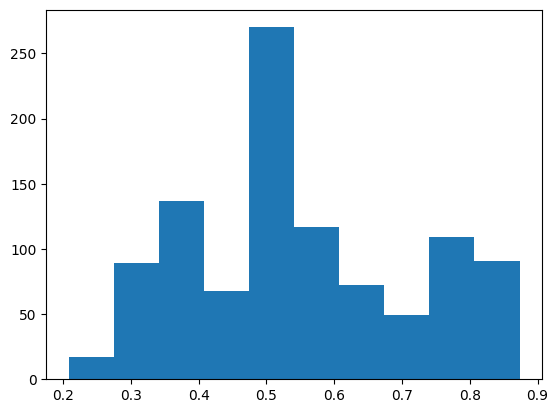

In [119]:
plt.hist(tmp['initsco'])

SpearmanrResult(correlation=0.07105710275467188, pvalue=0.31372810763270115)


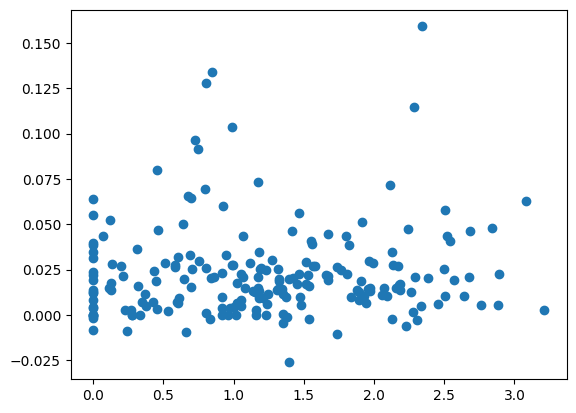

In [138]:
tmp = resdf[resdf['prefpercent']>0.9]
print(spearmanr(tmp['stat'], tmp['improves']))
plt.scatter(tmp['stat'],tmp['improves'])

In [112]:
BASE = "output/prefpreds/"
p0s = pd.read_json(BASE+"prefpreds0.jsonl",orient="records", lines=True)
p1s = pd.read_json(BASE+"prefpreds1.jsonl",orient="records", lines=True)
p2s = pd.read_json(BASE+"prefpreds2.jsonl",orient="records", lines=True)
p3s = pd.read_json(BASE+"prefpreds3.jsonl",orient="records", lines=True)
p4s = pd.read_json(BASE+"prefpreds4.jsonl",orient="records", lines=True)

In [8]:
sdf7 = pd.read_json(BASE+"verbprefpreds0_0.7.jsonl",orient="records", lines=True)
sdf3 = pd.read_json(BASE+"verbprefpreds0_0.3.jsonl",orient="records", lines=True)

In [9]:
def ascosdist(sdf):
    oscos = []
    nscos = []
    for i in range(len(sdf)):
        oscos.extend(sdf.iloc[i]['scos'][0])
        nscos.extend(sdf.iloc[i]['scos'][1])
    return oscos, nscos

(array([ 3.,  5.,  8.,  7., 20., 21., 33., 39., 38., 26.]),
 array([0.31463179, 0.38078749, 0.44694319, 0.51309889, 0.57925459,
        0.64541028, 0.71156598, 0.77772168, 0.84387738, 0.91003308,
        0.97618878]),
 <BarContainer object of 10 artists>)

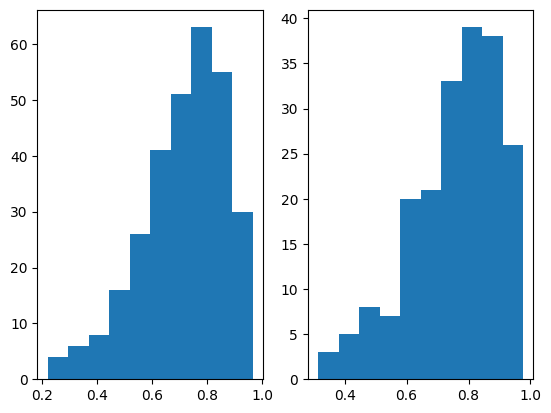

In [51]:
os, ns = ascosdist(sdf3)
fig, ax2 = plt.subplots(1,2)
ax2[0].hist(os)
ax2[1].hist(ns)


In [7]:
def showind_box(ind, sdf, newind):
    plt.boxplot(sdf['stats'].iloc[ind][newind]['entropy'], vert=True, meanline=True)
    plt.show()

In [8]:
def plot_lines(ind, sdf, newind, inax, metric='entropy'):
    row = sdf.iloc[ind]
    data = np.array(row['stats'][newind][metric])
    tokeddata = tokenizer(row['hyps'][newind], padding=True, truncation=True, return_tensors="pt").input_ids
    pinds = torch.sum(tokeddata==0, dim=1)
    linds = torch.sum(tokeddata>0, dim=1)
    print(linds)
    #print(data.shape)
    #print(tokeddata.shape)
    for i in range(4):
        # stats ignoring pad tokens
        if pinds[i]>0:
            ndata = data[:-int(pinds[i]), i]
        else:
            ndata = data[:, i]
        #print("de-padded data ", ndata.shape)
        s = linds[i]-len(ndata)#+pinds[i])
        #print("start ", s)
        #print("end ", linds[i])
        inax.plot(range(s, int(linds[i])), ndata , label=str(row['scos'][newind][i]))
    inax.legend()
    


tensor([47, 31, 75, 37])
tensor([31, 53, 44, 63])


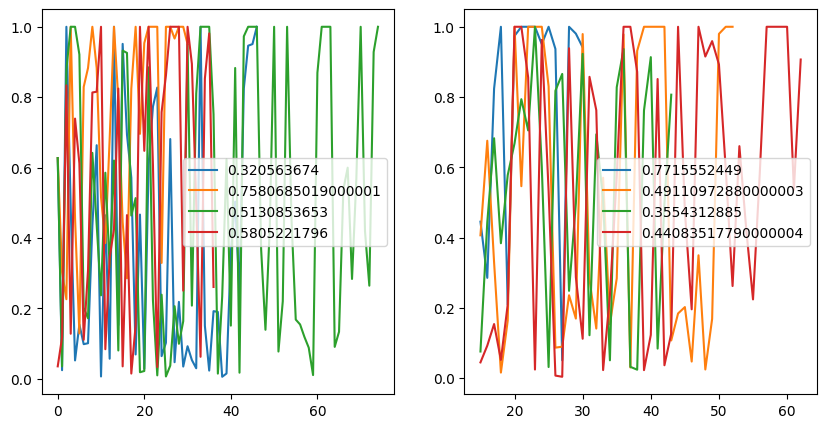

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# "mean", "stdev", "entropy", "skewness", "kurtoses", "top1s", "selected"
ind = 5
metric = "selected"
plot_lines(ind, sdf7, 0, ax[0],metric )
plot_lines(ind, sdf7, 1, ax[1], metric)

In [10]:
def preproc_metric(row, metric, newind):
    data = np.array(row['stats'][newind][metric])
    tokeddata = tokenizer(row['hyps'][newind], padding=True, truncation=True, return_tensors="pt").input_ids
    pinds = torch.sum(tokeddata==0, dim=1)
    linds = torch.sum(tokeddata>0, dim=1)
    #print(linds)
    starts = []
    ndatas = []
    for i in range(4):
        # stats ignoring pad tokens
        if pinds[i]>0:
            ndata = data[:-int(pinds[i]), i]
        else:
            ndata = data[:, i]
        #print("de-padded data ", ndata.shape)
        s = linds[i]-len(ndata)#+pinds[i])
        starts.append(s)
        ndatas.append(ndata)
    return starts, ndatas
    
def get_agg_stats(row, metric):
    _, origdatas = preproc_metric(row, metric, 0)
    prefixes, newdatas = preproc_metric(row, metric, 1)
    aggres = []
    o_pre_means = []
    o_post_means = []
    o_full_means = []
    n_post_means = []
    for i in range(0, 4):
        aggres.append({
            "opre":mean(origdatas[i][:prefixes[i]]),
            "opost":mean(origdatas[i][prefixes[i]:]),
            "ofull":mean(origdatas[i]),
            "shp":row['scos'][0][i]
        })
        aggres.append({
            "pfull":mean(newdatas[i]),
            "shp":row['scos'][1][i]
        })

    return aggres
    
def makedataset(sdf, metric):
    allrows = []
    for s in range(len(sdf)):
        allrows.extend(get_agg_stats(sdf.iloc[s], metric))
    return pd.DataFrame(allrows)

(array([35.,  0.,  1.,  2.,  1., 22., 79., 93., 31., 10.]),
 array([    0.        ,  3211.92156863,  6423.84313725,  9635.76470588,
        12847.68627451, 16059.60784314, 19271.52941176, 22483.45098039,
        25695.37254902, 28907.29411765, 32119.21568627]),
 <BarContainer object of 10 artists>)

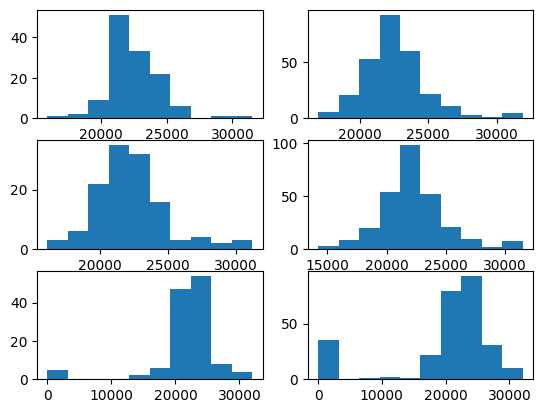

In [42]:
entdset = makedataset(sdf7, "kurtoses")
predata = entdset[entdset['opre']>0]
fig, ax = plt.subplots(3, 2)
good = predata[predata['shp']>.8]
ax[0][0].hist(list(good['ofull']))
ax[1][0].hist(list(good['opre']))
ax[2][0].hist(list(good['opost']))
good = predata[predata['shp']<.8]
ax[0][1].hist(list(good['ofull']))
ax[1][1].hist(list(good['opre']))
ax[2][1].hist(list(good['opost']))

,mean,stdev,entropy,skewness,kurtoses,top1s,selected,inpstrs,improves,initsco,prefpercent,prefix
0,0.000031,0.005326,0.2321,179.00,32070.0,0.9543,0.9543,The body naturally,-0.116369,0.850852,0.022556,3.0
1,0.000031,0.005579,0.0000,179.20,32120.0,1.0000,1.0000,The body naturally burn,-0.116918,0.850852,0.030075,4.0
2,0.000031,0.004141,1.0870,173.50,30690.0,0.7338,0.7338,The body naturally burns,-0.155831,0.850852,0.037594,5.0
3,0.000031,0.001755,2.7190,96.74,11510.0,0.2365,0.2365,The body naturally burns calories,-0.098341,0.850852,0.045113,6.0
4,0.000031,0.002951,1.7650,129.10,17730.0,0.4394,0.2772,The body naturally burns calories to,-0.354737,0.850852,0.052632,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3372,0.000031,0.002265,1.9960,88.34,8471.0,0.2567,0.1924,The laugh track was initially used to replace ...,0.016264,0.947469,0.952941,81.0
3373,0.000031,0.005579,0.0000,179.20,32120.0,1.0000,1.0000,The laugh track was initially used to replace ...,0.009833,0.947469,0.964706,82.0
3374,0.000031,0.005063,0.4376,178.50,31940.0,0.9062,0.9062,The laugh track was initially used to replace ...,0.009444,0.947469,0.976471,83.0
3375,0.000031,0.003017,1.4610,116.40,14620.0,0.4267,0.2257,The laugh track was initially used to replace ...,0.006975,0.947469,0.988235,84.0


In [14]:
row = sdf7.iloc[0]
print(len(row['stats'][0]['entropy']))
print(len(row['stats'][1]['entropy']))
tokeddata = tokenizer(row['hyps'][0], padding=True, truncation=True, return_tensors="pt").input_ids

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /tmp/ipykernel_1653044/32308483.py:1 in <module>                                          │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_1653044/32308483.py'                 │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'sdf7' is not defined

In [9]:
showind_box(0, statsdf3, 0)

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /tmp/ipykernel_1273216/1802039241.py:1 in <module>                                        │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_1273216/1802039241.py'               │
│ /tmp/ipykernel_1273216/3645042189.py:3 in showind_box                                     │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_1273216/3645042189.py'               │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 0

In [11]:
allps = pd.concat([p0s, p1s, p2s, p3s, p4s]).reset_index()

In [11]:
allps['scos'].iloc[0]

[[0.6351320744,
  0.6012812257,
  0.6015455127,
  0.4468139708,
  0.4857266545,
  0.8580931425],
 [0.5999557376, 0.4914311469, 0.6020961404, 0.7033241391]]

In [18]:
stdev(allps['scos'].iloc[0][0])

0.1443873014468865

In [11]:
def variance_changes(aps):
    origvars = []
    newvars = []
    for i in range(len(aps)):
        scovals = aps['scos'].iloc[i]
        origvars.append(stdev(scovals[0]))
        newvars.append(stdev(scovals[1]))
    return origvars, newvars

def ngram_changes(aps, n):
    origvars = []
    newvars = []
    for i in range(len(aps)):
        hyps = aps['hyps'].iloc[i]
        ongs = [len(get_unique_ngrams(h, tokenizer, n)) for h in hyps[0]]
        nngs = [len(get_unique_ngrams(h, tokenizer, n)) for h in hyps[1]]
        origvars.append(mean(ongs))
        newvars.append(mean(nngs))
    return origvars, newvars


# let's use this as our evaluation metric for diversity
def get_unique_ngrams(sentence, tok, n):
    uns = set()
    toks = tok(sentence).input_ids
    #print(toks)
    for i in range(len(toks)-n):
        tmp = ""
        for j in range(i, i+n):
            tmp = tmp+"_"+str(toks[j])
        uns.add(tmp)
    return uns

In [14]:
ov, nv = variance_changes(sdf7)

In [18]:
sdf7['varnew'] = nv

In [25]:
sdf7[sdf7['varnew']>0.2]['scos'].iloc[1]

[[0.3888301849, 0.5778717399000001, 0.4461915493, 0.42369952800000005],
 [0.843935132, 0.40807494520000004, 0.7288525701, 0.2776490748]]

(array([14., 17., 16., 13., 14.,  6., 10.,  4.,  3.,  3.]),
 array([0.01254368, 0.03576759, 0.05899151, 0.08221542, 0.10543933,
        0.12866324, 0.15188715, 0.17511106, 0.19833497, 0.22155888,
        0.24478279]),
 <BarContainer object of 10 artists>)

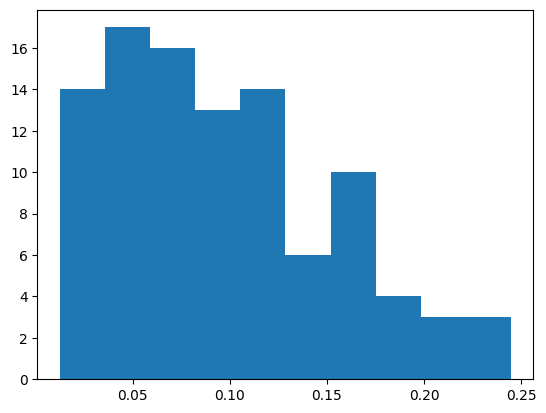

In [13]:
plt.hist(nv)

(array([21., 28., 22., 11.,  7.,  6.,  1.,  3.,  0.,  1.]),
 array([0.01007499, 0.03564115, 0.06120732, 0.08677349, 0.11233966,
        0.13790583, 0.163472  , 0.18903817, 0.21460434, 0.24017051,
        0.26573668]),
 <BarContainer object of 10 artists>)

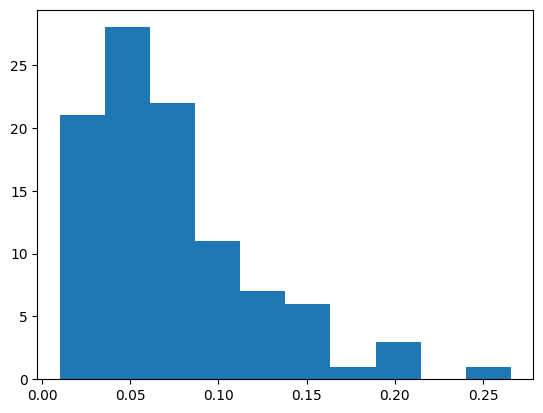

In [15]:
plt.hist(nv)

In [60]:
p3 = pd.read_json(BASE+"prefpreds0_0.7.jsonl",orient="records", lines=True)

In [61]:
print(p3['new_avg'].mean())
print(p3['old_avg'].mean())

0.8064980737820001
0.7130256715460002


In [40]:
orig_ngrams, new_ngrams = ngram_changes(p3, 1)
print(mean(new_ngrams))
print(mean(orig_ngrams))
orig_ngrams, new_ngrams = ngram_changes(p3, 3)
print(mean(new_ngrams))
print(mean(orig_ngrams))

43.115
36.60666666666666
61.67
49.94666666666667


In [41]:
ovs, nvs = variance_changes(p3)

In [42]:
print(mean(ovs))
print(mean(nvs))

0.11803499348864849
0.05760081108092043


(array([11., 14.,  6.,  5.,  5.,  4.,  2.,  0.,  1.,  2.]),
 array([ 24.5       ,  33.23333333,  41.96666667,  50.7       ,
         59.43333333,  68.16666667,  76.9       ,  85.63333333,
         94.36666667, 103.1       , 111.83333333]),
 <BarContainer object of 10 artists>)

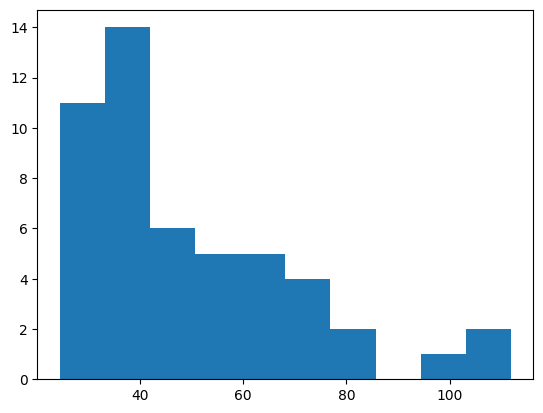

In [34]:
plt.hist(orig_ngrams)

In [15]:
diffdist = []
diffdist.extend(list(p0s['newmax']-p0s['oldmax']))
diffdist.extend(list(p1s['newmax']-p0s['oldmax']))
diffdist.extend(list(p2s['newmax']-p0s['oldmax']))
diffdist.extend(list(p3s['newmax']-p0s['oldmax']))
diffdist.extend(list(p4s['newmax']-p0s['oldmax']))


(array([ 7., 15., 17., 45., 50., 67., 24., 17.,  3.,  5.]),
 array([-0.22907507, -0.18476073, -0.14044639, -0.09613205, -0.0518177 ,
        -0.00750336,  0.03681098,  0.08112532,  0.12543967,  0.16975401,
         0.21406835]),
 <BarContainer object of 10 artists>)

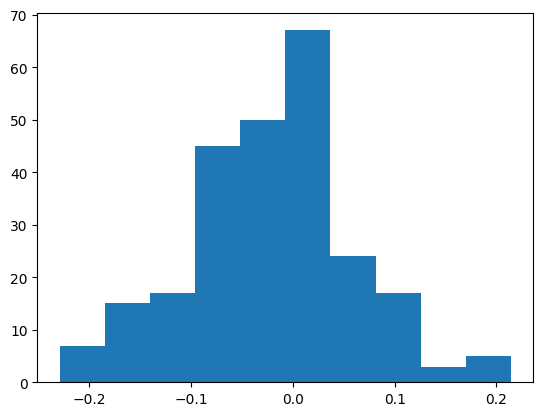

In [11]:
plt.hist(diffdist)

In [13]:
diffdist = []
diffdist.extend(list(p0s['new_avg']-p0s['old_avg']))
diffdist.extend(list(p1s['new_avg']-p0s['old_avg']))
diffdist.extend(list(p2s['new_avg']-p0s['old_avg']))
diffdist.extend(list(p3s['new_avg']-p0s['old_avg']))
diffdist.extend(list(p4s['new_avg']-p0s['old_avg']))


(array([ 1.,  1.,  3., 16., 40., 61., 71., 32., 18.,  7.]),
 array([-0.29910376, -0.24597837, -0.19285299, -0.1397276 , -0.08660221,
        -0.03347682,  0.01964856,  0.07277395,  0.12589934,  0.17902473,
         0.23215011]),
 <BarContainer object of 10 artists>)

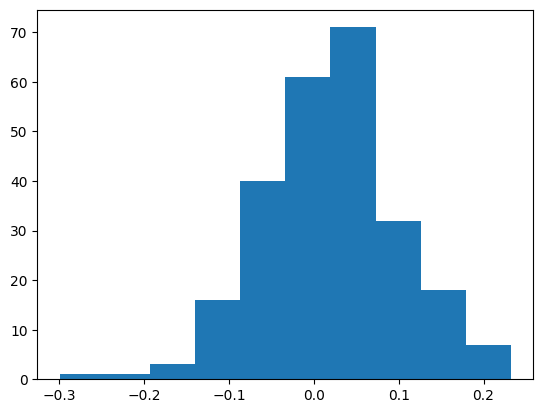

In [14]:
plt.hist(diffdist)